## Pneumonia Detection using X-Ray images

For this example we, will use the [Pneumonia Detection](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/) challenge from Kaggle. Objective of this challenge is to use X-Ray images and detect the early signs of Pneumonia by locating lung opacities in X-ray of chest. The dataset required can be downloaded from [here](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data).

As an initial start point, we will use [this](https://www.kaggle.com/yakhyo/rsna-classification-87-6-best-accuracy-opytorch) implementation. 

This implementation uses RESNET.

In [17]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pydicom import dcmread
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm


import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils import data

## Preparing labels

In [2]:
label_data = pd.read_csv('rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')
columns = ['patientId', 'Target']

label_data = label_data.filter(columns)
label_data.head(5)

,patientId,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0
4,00436515-870c-4b36-a041-de91049b9ab4,1


## Dividing labels for train and validation set

In [3]:
train_labels, val_labels = train_test_split(label_data.values, test_size=0.1)
print(train_labels.shape)
print(val_labels.shape)

(27204, 2)
(3023, 2)


In [4]:
print(f'patientId: {train_labels[0][0]}, Target: {train_labels[0][1]}')

patientId: 88d49b03-ce28-4de5-beb6-373ca79e78d7, Target: 0


## Preparing train and validation image paths

In [5]:
train_f = 'rsna-pneumonia-detection-challenge/stage_2_train_images'
test_f = 'rsna-pneumonia-detection-challenge/stage_2_test_images'

train_paths = [os.path.join(train_f, image[0]) for image in train_labels]
val_paths = [os.path.join(train_f, image[0]) for image in val_labels]

print(len(train_paths))
print(len(val_paths))

27204
3023


## Show some samples from data

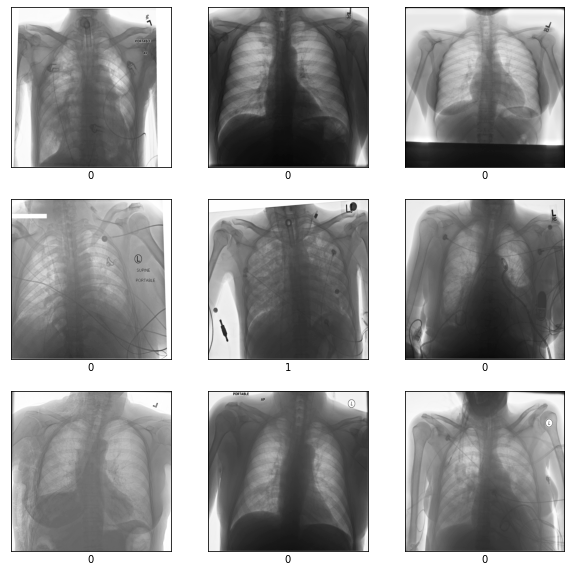

In [6]:
def imshow(num_to_show=9):
    
    plt.figure(figsize=(10,10))
    
    for i in range(num_to_show):
        plt.subplot(3, 3, i+1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        
        img_dcm = dcmread(f'{train_paths[i+20]}.dcm')
        img_np = img_dcm.pixel_array
        plt.imshow(img_np, cmap=plt.cm.binary)
        plt.xlabel(train_labels[i+20][1])

imshow()

## Composing transformations

In [7]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.ToTensor()])

## Write a custom dataset 

In [8]:
class Dataset(data.Dataset):
    
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform
    
    def __getitem__(self, index):
        image = dcmread(f'{self.paths[index]}.dcm')
        image = image.pixel_array
        image = image / 255.0

        image = (255*image).clip(0, 255).astype(np.uint8)
        image = Image.fromarray(image).convert('RGB')

        label = self.labels[index][1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label
    
    def __len__(self):
        
        return len(self.paths)

## Check the custom dataset

Tensor:tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.8039, 0.8627, 0.8706,  ..., 0.9373, 0.9373, 0.8824],
         [0.8078, 0.8667, 0.8745,  ..., 0.9373, 0.9412, 0.8824],
         [0.7647, 0.8275, 0.8314,  ..., 0.8902, 0.8902, 0.8314]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.8039, 0.8627, 0.8706,  ..., 0.9373, 0.9373, 0.8824],
         [0.8078, 0.8667, 0.8745,  ..., 0.9373, 0.9412, 0.8824],
         [0.7647, 0.8275, 0.8314,  ..., 0.8902, 0.8902, 0.8314]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0

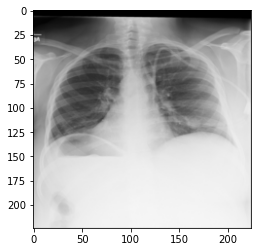

In [9]:
train_dataset = Dataset(train_paths, train_labels, transform=transform)
image = iter(train_dataset)
img, label = next(image)
print(f'Tensor:{img}, Label:{label}')
img = np.transpose(img, (1, 2, 0))
plt.imshow(img)

## Train image shape

In [10]:
img.shape

torch.Size([224, 224, 3])

## Prepare training and validation dataloader

In [11]:
train_dataset = Dataset(train_paths, train_labels, transform=transform)
val_dataset = Dataset(val_paths, val_labels, transform=transform)
train_loader = data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=128, shuffle=False)

## Check dataloader

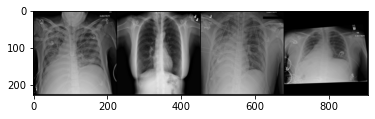

In [12]:
batch = iter(train_loader)
images, labels = next(batch)

image_grid = torchvision.utils.make_grid(images[:4])
image_np = image_grid.numpy()
img = np.transpose(image_np, (1, 2, 0))
plt.imshow(img)

## Specify device object

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load pre-trained ResNet18 and fine-tune

In [14]:
model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 2)

model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/adm.akram/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 43.8MB/s]


In [15]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Write a train code and RUN

In [16]:
num_epochs = 20
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    # Training step
    for i, (images, labels) in tqdm(enumerate(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 2000 == 0:
            
            print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))


    # Validation step
    correct = 0
    total = 0  
    for images, labels in tqdm(val_loader):
        images = images.to(device)
        labels = labels.to(device)
        predictions = model(images)
        _, predicted = torch.max(predictions, 1)
        total += labels.size(0)
        correct += (labels == predicted).sum()
    print(f'Epoch: {epoch+1}/{num_epochs}, Val_Acc: {100*correct/total}')

213it [06:56,  1.95s/it]
100%|██████████| 24/24 [00:44<00:00,  1.84s/it]
0it [00:00, ?it/s]

Epoch: 1/20, Val_Acc: 81


213it [06:31,  1.84s/it]
100%|██████████| 24/24 [00:43<00:00,  1.82s/it]
0it [00:00, ?it/s]

Epoch: 2/20, Val_Acc: 82


213it [06:41,  1.88s/it]
100%|██████████| 24/24 [00:43<00:00,  1.80s/it]
0it [00:00, ?it/s]

Epoch: 3/20, Val_Acc: 82


213it [06:39,  1.88s/it]
100%|██████████| 24/24 [00:42<00:00,  1.77s/it]
0it [00:00, ?it/s]

Epoch: 4/20, Val_Acc: 82


213it [06:30,  1.83s/it]
100%|██████████| 24/24 [00:39<00:00,  1.64s/it]
0it [00:00, ?it/s]

Epoch: 5/20, Val_Acc: 82


213it [06:11,  1.74s/it]
100%|██████████| 24/24 [00:42<00:00,  1.77s/it]
0it [00:00, ?it/s]

Epoch: 6/20, Val_Acc: 83


213it [06:24,  1.81s/it]
100%|██████████| 24/24 [00:42<00:00,  1.76s/it]
0it [00:00, ?it/s]

Epoch: 7/20, Val_Acc: 82


213it [06:29,  1.83s/it]
100%|██████████| 24/24 [00:43<00:00,  1.82s/it]
0it [00:00, ?it/s]

Epoch: 8/20, Val_Acc: 83


213it [06:43,  1.90s/it]
100%|██████████| 24/24 [00:44<00:00,  1.85s/it]
0it [00:00, ?it/s]

Epoch: 9/20, Val_Acc: 84


213it [06:24,  1.81s/it]
100%|██████████| 24/24 [00:41<00:00,  1.74s/it]
0it [00:00, ?it/s]

Epoch: 10/20, Val_Acc: 84


213it [06:32,  1.84s/it]
100%|██████████| 24/24 [00:44<00:00,  1.85s/it]
0it [00:00, ?it/s]

Epoch: 11/20, Val_Acc: 84


213it [06:36,  1.86s/it]
100%|██████████| 24/24 [00:42<00:00,  1.75s/it]
0it [00:00, ?it/s]

Epoch: 12/20, Val_Acc: 85


213it [06:10,  1.74s/it]
100%|██████████| 24/24 [00:41<00:00,  1.71s/it]
0it [00:00, ?it/s]

Epoch: 13/20, Val_Acc: 86


213it [06:26,  1.81s/it]
100%|██████████| 24/24 [00:40<00:00,  1.68s/it]
0it [00:00, ?it/s]

Epoch: 14/20, Val_Acc: 85


213it [06:20,  1.79s/it]
100%|██████████| 24/24 [00:43<00:00,  1.82s/it]
0it [00:00, ?it/s]

Epoch: 15/20, Val_Acc: 86


213it [06:43,  1.89s/it]
100%|██████████| 24/24 [00:45<00:00,  1.88s/it]
0it [00:00, ?it/s]

Epoch: 16/20, Val_Acc: 87


213it [06:56,  1.95s/it]
100%|██████████| 24/24 [00:43<00:00,  1.82s/it]
0it [00:00, ?it/s]

Epoch: 17/20, Val_Acc: 87


213it [06:54,  1.95s/it]
100%|██████████| 24/24 [00:45<00:00,  1.89s/it]
0it [00:00, ?it/s]

Epoch: 18/20, Val_Acc: 87


213it [06:53,  1.94s/it]
100%|██████████| 24/24 [00:42<00:00,  1.76s/it]
0it [00:00, ?it/s]

Epoch: 19/20, Val_Acc: 87


213it [06:34,  1.85s/it]
100%|██████████| 24/24 [00:43<00:00,  1.83s/it]

Epoch: 20/20, Val_Acc: 87


## Test model

In [18]:
model.eval()

correct = 0
total = 0  
for images, labels in tqdm(val_loader):
    images = images.to(device)
    labels = labels.to(device)
    predictions = model(images)
    _, predicted = torch.max(predictions, 1)
    total += labels.size(0)
    correct += (labels == predicted).sum()
print(f'Val_Acc: {100*correct/total}')

100%|██████████| 24/24 [00:44<00:00,  1.84s/it]

Val_Acc: 87


## Save the Model weights

In [19]:
torch.save(model.state_dict(), 'weights/weights_only.pth')
torch.save(model, 'model/model.pth')
print("Model and weights saved.")

Model and weights saved.


/home/adm.akram/anaconda3/envs/medi/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/adm.akram/anaconda3/envs/medi/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/adm.akram/anaconda3/envs/medi/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/adm.akram/anaconda3/envs/medi/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correct

## Load saved model

In [23]:
model = torch.load('model/model.pth')

## Visualisation using CAM and GradCAM

In [24]:
# TO Do